<a href="https://colab.research.google.com/github/tkhan3/machinelearning/blob/master/HR_Analytics_15000_rec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}
#import pandas as pd
!google-drive-ocamlfuse drive
!apt-get -qq install -y graphviz && pip install -q pydot
!pip3 install seaborn==0.9.0
import pydot
!mkdir -p drive
!google-drive-ocamlfuse drive
!pip install sklearn_pandas

E: Package 'python-software-properties' has no installation candidate


In [2]:
import pandas as pd
from datetime import datetime
import seaborn as sns
import os
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.impute import SimpleImputer # Scikit-Learn 0.20+
from sklearn.metrics import (accuracy_score, log_loss, classification_report)
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
#import itertools
from xgboost import XGBClassifier
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


In [0]:
import os
drive_path = 'drive/DL_COLAB/'

HR_ANALYTICS_PATH = os.path.join(drive_path,"hr_analytics")

def load_hr_data(filename, file_path=HR_ANALYTICS_PATH):
    csv_path = os.path.join(file_path, filename)
    return pd.read_csv(csv_path,sep=",")

In [0]:
hr_data_full = load_hr_data("HR_15000_record.csv")

In [5]:
hr_data_full.shape

(14999, 10)

In [6]:
hr_data_full.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident', 'left',
       'promotion_last_5years', 'sales', 'salary'],
      dtype='object')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7faffdc56550>,
      dtype=object)

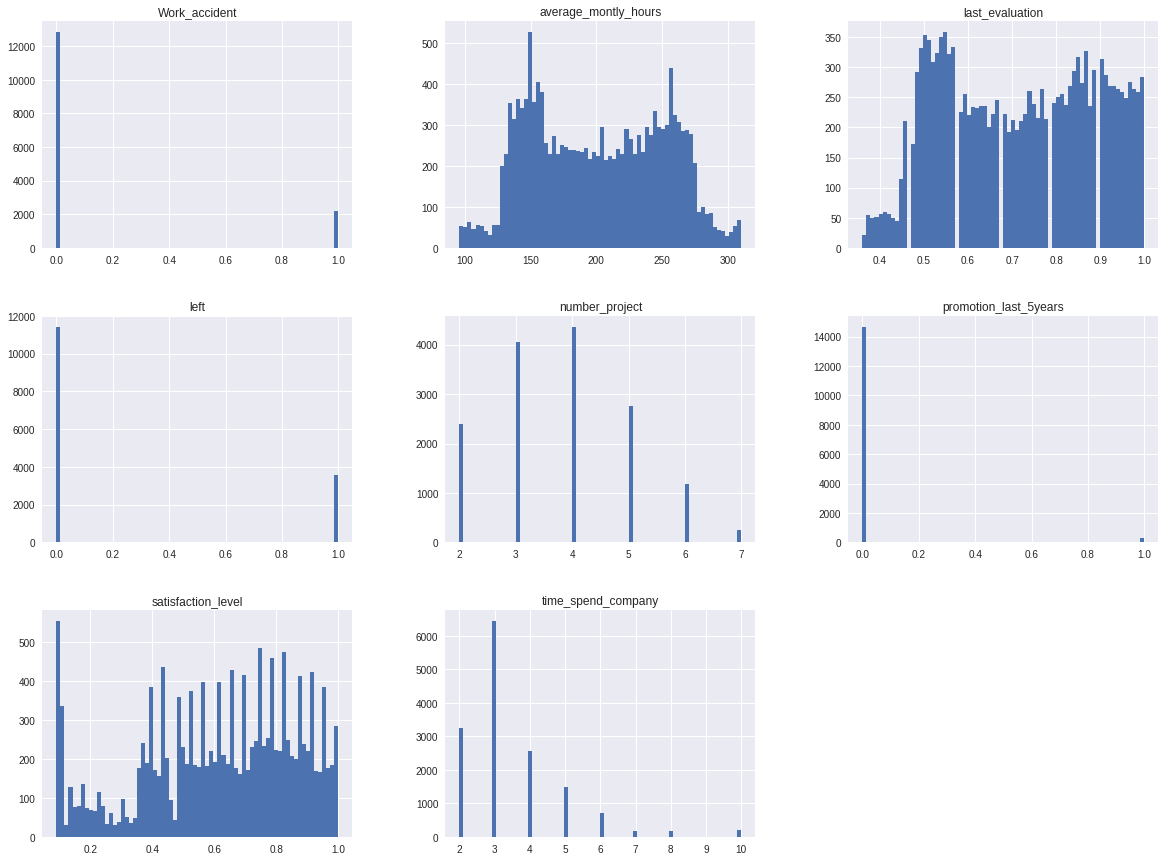

In [7]:
hr_data_full.hist(bins=70, figsize=(20,15))

In [8]:
print (hr_data_full.salary.unique())
print (hr_data_full.sales.unique())

['low' 'medium' 'high']
['sales' 'accounting' 'hr' 'technical' 'support' 'management' 'IT'
 'product_mng' 'marketing' 'RandD']


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  cat_pos = np.ones(swarm_data.size) * center


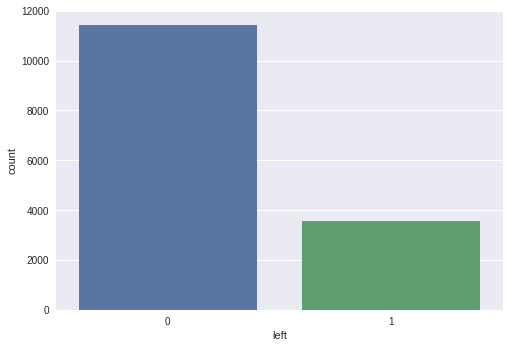

In [9]:
sns.countplot(x="left",data=hr_data_full)

In [0]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
for train_index, test_index in split.split(hr_data_full, hr_data_full["left"]):
    hr_data_train = hr_data_full.loc[train_index]
    hr_data_test = hr_data_full.loc[test_index]

In [11]:
print (hr_data_train.shape)
print (hr_data_test.shape)

(13499, 10)
(1500, 10)


In [12]:
print (type(hr_data_train))
print (type(hr_data_test))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [0]:
hr_data_train_label = hr_data_train["left"].copy()
hr_data_test_label =  hr_data_test["left"].copy()


In [14]:
print (hr_data_train_label.shape)
print (hr_data_test_label.shape)

(13499,)
(1500,)


In [0]:
hr_data_train = hr_data_train.drop("left",axis=1)
hr_data_test = hr_data_test.drop("left",axis=1)

In [16]:
hr_data_train.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years
count,13499.00000,13499.000000,13499.000000,13499.000000,13499.000000,13499.000000,13499.000000
mean,0.61276,0.716707,3.806430,201.149567,3.503445,0.144529,0.020890
std,0.24897,0.171250,1.234811,49.969348,1.461173,0.351639,0.143023
min,0.09000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000
25%,0.44000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000
50%,0.64000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000
75%,0.82000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000
max,1.00000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000


In [17]:
hr_data_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
satisfaction_level       14999 non-null float64
last_evaluation          14999 non-null float64
number_project           14999 non-null int64
average_montly_hours     14999 non-null int64
time_spend_company       14999 non-null int64
Work_accident            14999 non-null int64
left                     14999 non-null int64
promotion_last_5years    14999 non-null int64
sales                    14999 non-null object
salary                   14999 non-null object
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [0]:
cat_attribute = ['sales','salary']
numeric_attribute = ["satisfaction_level","last_evaluation","number_project","average_montly_hours","time_spend_company","Work_accident","promotion_last_5years"]

In [0]:
# Create a class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [0]:
# Inspired from stackoverflow.com/questions/25239958
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],index=X.columns)
        return self
    def transform(self, X, y=None):
        #return X.fillna(self.most_frequent_)
        return X


In [0]:
num_pipeline = Pipeline([
        ("select_numeric", DataFrameSelector(numeric_attribute)),
        ("imputer", SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

In [0]:
cat_pipeline = Pipeline([
        ("select_cat", DataFrameSelector(cat_attribute)),
 #       ("imputer", CategoricalImputer()),
        ("cat_encoder",OneHotEncoder(sparse=False,handle_unknown='ignore' )),
        ])

In [0]:
from sklearn_pandas import *

In [0]:
preprocess_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

In [0]:
x_train  = preprocess_pipeline.fit_transform(hr_data_train)
x_test =  preprocess_pipeline.transform(hr_data_test)

In [67]:
print (type(x_train))

<class 'numpy.ndarray'>


In [0]:
le = preprocessing.LabelEncoder()
y_train = le.fit_transform(hr_data_train_label)
y_test = le.fit_transform(hr_data_test_label)

In [43]:
print (x_train.shape)
print (x_test.shape)
print (y_train.shape)
print (y_test.shape)
print (hr_data_train.shape)

(13499, 20)
(1500, 20)
(13499,)
(1500,)
(13499, 9)


In [0]:
correlation_matrix = hr_data_train.corr()

In [45]:
print (correlation_matrix)

                       satisfaction_level  last_evaluation  number_project  \
satisfaction_level               1.000000         0.105310       -0.146906   
last_evaluation                  0.105310         1.000000        0.346520   
number_project                  -0.146906         0.346520        1.000000   
average_montly_hours            -0.021872         0.338556        0.417131   
time_spend_company              -0.099282         0.134387        0.196456   
Work_accident                    0.060839        -0.008767       -0.003130   
promotion_last_5years            0.029235        -0.005600       -0.005627   

                       average_montly_hours  time_spend_company  \
satisfaction_level                -0.021872           -0.099282   
last_evaluation                    0.338556            0.134387   
number_project                     0.417131            0.196456   
average_montly_hours               1.000000            0.127994   
time_spend_company                 0.127

In [0]:
mask = np.zeros_like(correlation_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

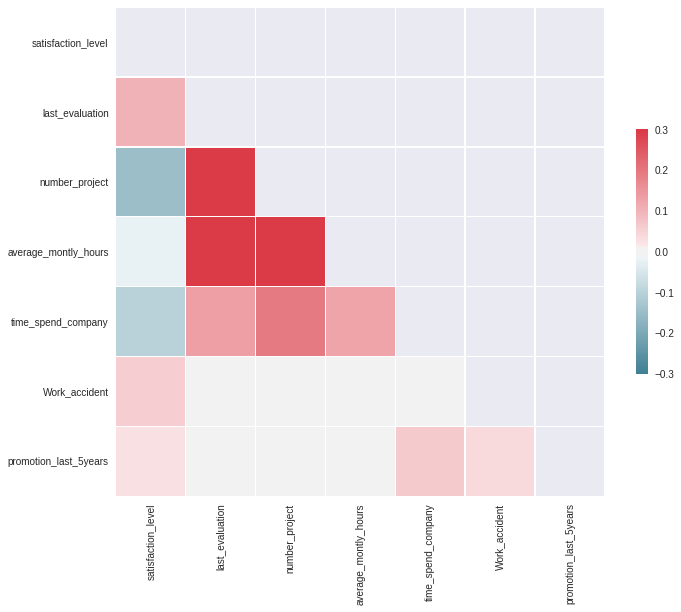

In [47]:
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [0]:
logistic_clf = LogisticRegression(random_state=42,class_weight ='balanced',solver='lbfgs',max_iter=1000)

In [55]:
logistic_clf.fit(x_train,y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=1000,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=42,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)

In [69]:
logistic_regression_scores = cross_val_score(logistic_clf, x_train, y_train, cv=10)
y_train_pred_logistic = cross_val_predict(logistic_clf, x_train, y_train, cv=10)
print (logistic_regression_scores.mean())

AttributeError: ignored

In [0]:
confusion_matrix(y_train, y_train_pred_logistic)

array([[7666, 2619],
       [ 643, 2571]])

In [0]:
y_test_pred_logistic = logistic_clf.predict(x_test)

In [61]:
confusion_matrix(y_test, y_test_pred_logistic)

array([[886, 257],
       [ 68, 289]])

In [62]:
cm = confusion_matrix(y_train,y_train_pred_logistic)
tn, fp, fn, tp = cm.ravel()
print (tn)
print (fp)
print (fn)
print (tp)

NameError: ignored

Confusion matrix, without normalization
[[10285     0]
 [    0  3214]]


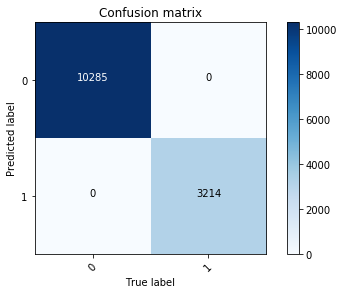

In [87]:
plot_confusion_matrix(cm,[0,1])

In [0]:
tn, fp, fn, tp = confusion_matrix(y_test,y_test_pred_logistic).ravel()
print (tn)
print (fp)
print (fn)
print (tp)

886
257
68
289


In [63]:
param_grid = [{"weights":["uniform","distance"],"n_neighbors":[2,3,4,5]}]
knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv=10, verbose=3, n_jobs=-1)
grid_search.fit(x_train, y_train)
print (grid_search.best_params_)

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


AttributeError: ignored

In [36]:
knn_clf = KNeighborsClassifier(weights='distance',n_neighbors=2)
knn_clf.fit(x_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=2, p=2,
           weights='distance')

In [37]:
knn_scores = cross_val_score(knn_clf, x_train, y_train, cv=10)
y_train_pred_knn = cross_val_predict(knn_clf, x_train, y_train, cv=10)
print (knn_scores.mean())

AttributeError: ignored

In [88]:
cm  = confusion_matrix(y_train,y_train_pred_knn)
tn, fp, fn, tp = cm.ravel()
print (tn)
print (fp)
print (fn)
print (tp)

9984
301
125
3089


Confusion matrix, without normalization
[[9984  301]
 [ 125 3089]]


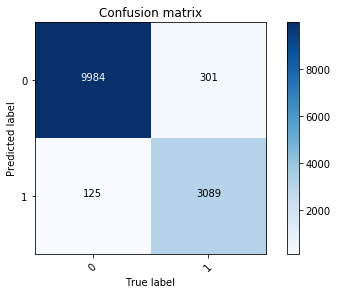

In [89]:
plot_confusion_matrix(cm,[0,1])

In [0]:
y_test_pred_knn = knn_clf.predict(x_test)

In [82]:
cm = confusion_matrix(y_test,y_test_pred_knn)
tn, fp, fn, tp = cm.ravel()
print (tn)
print (fp)
print (fn)
print (tp)

1110
33
12
345


In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Predicted label')
    plt.xlabel('True label')

Confusion matrix, without normalization
[[1110   33]
 [  12  345]]


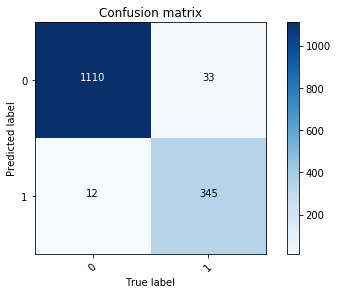

In [85]:
plot_confusion_matrix(cm,[0,1])

In [90]:
classification_report(y_test,y_test_pred_knn)

'              precision    recall  f1-score   support\n\n           0       0.99      0.97      0.98      1143\n           1       0.91      0.97      0.94       357\n\n   micro avg       0.97      0.97      0.97      1500\n   macro avg       0.95      0.97      0.96      1500\nweighted avg       0.97      0.97      0.97      1500\n'

In [91]:
#train SVM Based Model
svm_clf = SVC(gamma="auto",random_state=42)
svm_clf.fit(x_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False)

In [93]:
svm_scores = cross_val_score(knn_clf, x_train, y_train, cv=10)
y_train_pred_svm = cross_val_predict(svm_clf, x_train, y_train, cv=10)
print (svm_scores.mean())

0.9684432766949849


In [0]:
y_test_pred_svm = svm_clf.predict(x_test)

In [99]:
cm  = confusion_matrix(y_test,y_test_pred_svm)
tn, fp, fn, tp = cm.ravel()
print (tn)
print (fp)
print (fn)
print (tp)

1115
28
37
320


In [98]:
classification_report(y_test,y_test_pred_svm)

'              precision    recall  f1-score   support\n\n           0       0.97      0.98      0.97      1143\n           1       0.92      0.90      0.91       357\n\n   micro avg       0.96      0.96      0.96      1500\n   macro avg       0.94      0.94      0.94      1500\nweighted avg       0.96      0.96      0.96      1500\n'

Confusion matrix, without normalization
[[1115   28]
 [  37  320]]


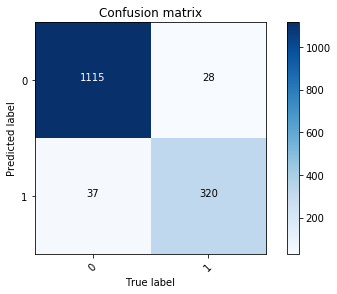

In [101]:
plot_confusion_matrix(cm,[0,1])

In [103]:
xgboost_clf = XGBClassifier(random_state=42)
xgboost_clf.fit(x_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [104]:
xgboost_scores = cross_val_score(xgboost_clf, x_train, y_train, cv=10)
y_train_pred_xgboost = cross_val_predict(xgboost_clf, x_train, y_train, cv=10)
xgboost_scores.mean()

0.9750372992329845

In [105]:
cm  = confusion_matrix(y_train,y_train_pred_xgboost)
tn, fp, fn, tp = cm.ravel()
print (tn)
print (fp)
print (fn)
print (tp)

10183
102
235
2979


Confusion matrix, without normalization
[[10183   102]
 [  235  2979]]


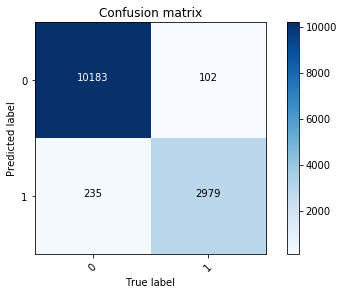

In [107]:
plot_confusion_matrix(cm,[0,1])

In [0]:
y_test_pred_xgboost = xgboost_clf.predict(x_test)

In [109]:
cm  = confusion_matrix(y_test,y_test_pred_xgboost)
tn, fp, fn, tp = cm.ravel()
print (tn)
print (fp)
print (fn)
print (tp)

1135
8
25
332


Confusion matrix, without normalization
[[1135    8]
 [  25  332]]


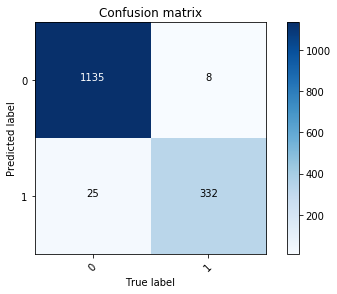

In [110]:
plot_confusion_matrix(cm,[0,1])

In [112]:
x_train.shape

(13499, 20)

In [0]:
# create model
neural_net = Sequential()
neural_net.add(Dense(8, input_dim=20, activation='relu'))
#neural_net.add(Dense(12, activation='relu'))
#neural_net.add(Dense(12, activation='relu'))
#neural_net.add(Dense(12, activation='relu'))
neural_net.add(Dense(12, activation='relu'))
neural_net.add(Dense(1, activation='sigmoid'))
# Compile model
neural_net.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
neural_net.fit(x_train, y_train, validation_split=0.1,epochs=1500, batch_size=10)

Train on 12149 samples, validate on 1350 samples
Epoch 1/1500
12149/12149 [==============================] - 8s 631us/step - loss: 0.3696 - acc: 0.8428 - val_loss: 0.2169 - val_acc: 0.9281
Epoch 2/1500
12149/12149 [==============================] - 6s 465us/step - loss: 0.1938 - acc: 0.9384 - val_loss: 0.1781 - val_acc: 0.9452
Epoch 3/1500
12149/12149 [==============================] - 6s 458us/step - loss: 0.1715 - acc: 0.9467 - val_loss: 0.1631 - val_acc: 0.9489
Epoch 4/1500
12149/12149 [==============================] - 6s 457us/step - loss: 0.1614 - acc: 0.9490 - val_loss: 0.1540 - val_acc: 0.9526
Epoch 5/1500
12149/12149 [==============================] - 5s 450us/step - loss: 0.1562 - acc: 0.9511 - val_loss: 0.1497 - val_acc: 0.9563
Epoch 6/1500
12149/12149 [==============================] - 5s 450us/step - loss: 0.1518 - acc: 0.9550 - val_loss: 0.1465 - val_acc: 0.9578
Epoch 7/1500
12149/12149 [==============================] - 6s 453us/step - loss: 0.1491 - acc: 0.9561 - val_lo

In [1]:
y_train_pred_neural_net = neural_net.predict_classes(x_train)

NameError: ignored